 <font size="20"> Heart Disease </font>

INTRODUCTION:





PRELIMINARY EXPLORATORY DATA ANALYSIS:

In [66]:
library(tidyverse)
library(repr)
library(tidymodels)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read.csv(file = url) |>
rename(age=X63.0,
       sex=X1.0,
       chest_pain=X1.0.1,
       resting_blood_pressure=X145.0,
       cholesterol=X233.0,
       fasting_blood_sugar=X1.0.2,
       resting_electrocardiographic_results=X2.0,
       max_heart_rate=X150.0,
       exercise_induced_angina=X0.0,
       S_depression_induced=X2.3,
       slope_of_peak_exercise=X3.0,
       major_vessels=X0.0.1,
       thal=X6.0,
       heart_disease_diagnosis=X0)
heart_data


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [83]:
#Selected columns (sex, cholesterol and heart_disease_diagnosis) from heart data.
heart_data_selected <- select(heart_data, sex, cholesterol, heart_disease_diagnosis) |>
                        arrange(sex, cholesterol)
heart_data_selected

sex,cholesterol,heart_disease_diagnosis
<dbl>,<dbl>,<int>
0,141,0
0,149,0
0,160,0
⋮,⋮,⋮
1,335,1
1,335,2
1,353,3


In [62]:
#The table below reports the average cholesterol level for males(1) and females(0).
sex_vs_cholesterol <- group_by(heart_data_selected, sex) |>
                      summarize(cholesterol=mean(cholesterol, na.rm=TRUE))
sex_vs_cholesterol

sex,cholesterol
<dbl>,<dbl>
0,261.7526
1,239.6341


In [63]:
#The table below reports the average heart disease diagnosis (on a scale of 0-4) for males(1) and females(0).
sex_vs_heart_disease <- group_by(heart_data_selected, sex) |>
                        summarize(heart_disease_diagnosis=mean(heart_disease_diagnosis, na.rm=TRUE))
sex_vs_heart_disease

sex,heart_disease_diagnosis
<dbl>,<dbl>
0,0.5360825
1,1.1317073


In [67]:
#The table below reports the average cholesterol level for each heart disease diagnosis level (0-4).
heart_disease_vs_cholesterol <- group_by(heart_data_selected, heart_disease_diagnosis) |>
                                summarize(cholesterol=mean(cholesterol, na.rm=TRUE))
heart_disease_vs_cholesterol

heart_disease_diagnosis,cholesterol
<int>,<dbl>
0,242.6994
1,249.1091
2,259.2778
3,246.4571
4,253.3846


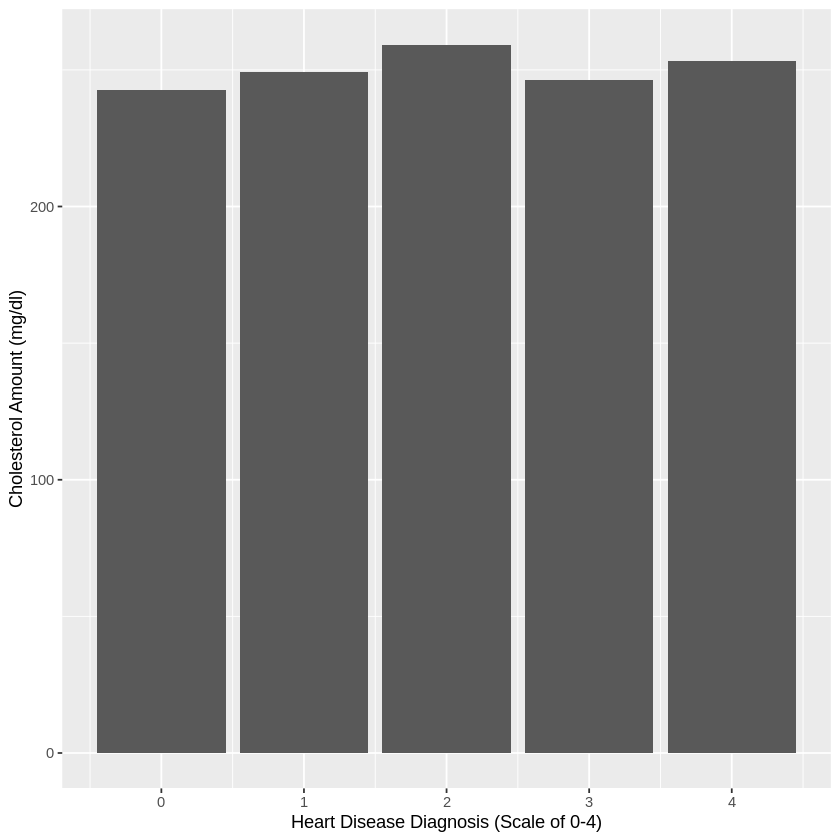

In [94]:
#Bar plot of heart disease level (0-4) vs cholesterol amount (mg/dl).
plot_heart_disease_vs_cholesterol <- heart_disease_vs_cholesterol |>
                            ggplot(aes(x=heart_disease_diagnosis, y=cholesterol)) +
                                 geom_bar(stat="identity") +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Cholesterol Amount (mg/dl)")
plot_heart_disease_vs_cholesterol
                                 